### Vediamo come costruire e allenare un regressore lineare con PyTorch. Carichiamo il dataset Boston con scikit-learn

In [6]:
%pip install torch
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Regressione Lineare

In [7]:
from sklearn.datasets import fetch_openml
boston = fetch_openml(name="boston", version=1)
print(boston.DESCR)

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10

Il dataset consiste in 506 osservazioni, ognuna di esse ha 13 valori che costituiscono rilevamenti di vicinati di Boston.


In [8]:
X = boston.data.to_numpy().astype(float)
Y = boston.target.to_numpy().astype(float)

X sono i rilevamenti, quindi sono 506 quartieri con ognuno contenente 13 rilevamenti
Y sono i valori mediani delle case in ognuno dei vicinati espressi in multipli di 1000

Calcoliamo una permutazione casuale degli indici.

In [9]:
import numpy as np
import torch

np.random.seed(123)
torch.random.manual_seed(123)

idx = np.random.permutation(len(X))

# Applichiamo la stessa permutazione a rilevamenti e target
X = X[idx]
Y = Y[idx]

#### Adesso suddividiamo il dataset in training e testing selezionando i primi 50 valori per formare il testing set.

#### Trasformiamo gli array in tensori e inseriamoli in delle variabili.

In [10]:
X_training = torch.Tensor(X[50:])
Y_training = torch.Tensor(Y[50:])
X_testing = torch.Tensor(X[:50])
Y_testing = torch.Tensor(Y[:50])

### Q1: Perchè abbiamo effetuato una permutazione casuale dei dati prima di dividerli in training e test?


Perchè così se il dataset ha un bias andiamo a renderlo omogeneo e dividiamo correttamente tra train e test

Il modello di regressione dipende da 14 parametri:
- 13 sono le features in ingresso
- 1 l'intercetta della retta
Iniializziamo l'array dei pesi $\theta$ casualmente con distribuzione normale media zero varianza 0.1 così che inizialmente abbia valori sia positivi che negativi 

Definiamo una variabile per l'intercetta, ovvero theta_0

Il bias in un modello di regressione lineare è l'intercetta della retta, ovvero il valore che la funzione di regressione assume quando tutte le variabili indipendenti sono pari a zero.

La funzione del modello è:
$$
y(x) = \theta_1x_1+...+\theta_{13}x_{13}+\theta_0
$$

In [11]:
theta = torch.Tensor(13) # Tensore da 13 unità
theta_0 = torch.Tensor(1) # Bias

theta.requires_grad_(True)
theta_0.requires_grad_(True)

theta.data.normal_(0,0.1)
theta_0.data.normal_(0,0.1)

print(theta)
print(theta_0)

tensor([-0.0111,  0.0120, -0.0370, -0.0240, -0.1197,  0.0209, -0.0972, -0.0755,
         0.0324, -0.0109,  0.0210, -0.0391,  0.0235], requires_grad=True)
tensor([0.0665], requires_grad=True)


In PyTorch, l'attributo requires_grad è fondamentale per il calcolo automatico del gradiente e l'ottimizzazione dei modelli di machine learning.

Quando un tensore ha requires_grad=True, PyTorch tiene traccia delle operazioni fatte su di esso, costruendo un grafo computazionale dinamico. Questo permette di calcolare automaticamente i gradienti tramite backpropagation, essenziali per l'ottimizzazione del modello

In [12]:
def linear_regression(input, theta, theta_0):
    return input.mul(theta).sum(1)+theta_0

Abbiamo moltiplicato ogni riga di X_training per il vettore theta, quindi stiamo formando l'equazione di regressione lineare. Infine, sommiamo lungo l'asse. Questo restituisce per ogni la combinazione lineare a cui sommiamo theta_0

In [13]:
y = linear_regression(X_training, theta, theta_0)
print(y[:10])

tensor([-20.8190, -23.3360, -24.6247, -31.4600, -27.4998, -28.1950, -27.1047,
        -26.2724, -18.8539, -31.4594], grad_fn=<SliceBackward0>)


Confrontiamo questi valori con i veri valori quindi Ground Truth

In [14]:
print(Y_training[:10])

tensor([32.4000, 29.6000, 20.4000, 12.3000, 19.1000, 14.9000, 17.8000,  8.8000,
        35.4000, 11.5000])


I valori sono molto diversi ed è normale perchè il modello per ora usa pesi inizializzati a caso, adesso dobbiamo ottimizzare il modello tramite la discesa del gradiente. Per farlo definiamo una funzione di loss cioè una funzione differenziabile che esprime l'errore che il modello commette.

Qui useremo Mean Squared Error.
$$
MSE(y, \hat y) = \frac 1N \sum_i^N(\hat y_i - y_i)^2
$$

dove $\hat y$ sono le predizioni, mentre $y$ sono le ground truth e N il numero di campioni

In [15]:
def loss(input, target):
    return ((input-target)**2).mean()

In [16]:
print(loss(y,Y_training))

tensor(2274.0801, grad_fn=<MeanBackward0>)


è un numero molto grande perchè le predizioni sono molto distanti dalle GT. Adesso applichiamo la discesa del gradiente. 

$$
L_\theta(x,y)=\frac1N \sum_i^N (\theta_0 + \sum_i (x_i\theta_i)-y_i)^2
$$

Discesa del gradiente:
1. Normalizza i dati
2. Inizializza i parametri opportunamente
3. Calcola le predizioni $\hat y = \sum_i (\theta_i x_i)+\theta_0$
4. Calcola la loss function
5. Calcola il gradiente dei parametri rispetto la loss function
6. Aggiorna i pesi seguendo la regola $\theta = \theta -\eta GradienteLF$
7. Ripeti 3-6 fino a convergenza

In pratica il punto 7 consiste nel settare un numero di iterazioni dette epoche. Dato che ogni feature ha unità di misura diverse è ovvio che la normalizzazione serve.

In [17]:
means = X_training.mean(0) # media lungo la dimensione zero
stds = X_training.std(0)
print(means, stds)


tensor([3.5481e+00, 1.1293e+01, 1.1224e+01, 6.1404e-02, 5.5591e-01, 6.2701e+00,
        6.8338e+01, 3.7963e+00, 9.5658e+00, 4.0893e+02, 1.8468e+01, 3.5775e+02,
        1.2820e+01]) tensor([8.4949e+00, 2.3287e+01, 6.9195e+00, 2.4033e-01, 1.1805e-01, 6.9616e-01,
        2.8338e+01, 2.1295e+00, 8.7019e+00, 1.6880e+02, 2.1430e+00, 9.0201e+01,
        7.1928e+00])


Noto che le 12 variabili hanno medie e deviazioni standard molto diverse, uniformiamole con Z-scoring

In [18]:
X_training_norm = (X_training-means)/stds

Adesso le variabili hanno medie prossime allo zero e std pari a 1

In [19]:
print(X_training_norm.mean(0))
print(X_training_norm.std(0))

tensor([ 0.0000e+00,  7.3199e-09,  1.2914e-07,  2.0914e-09,  3.1685e-07,
        -4.2664e-07,  9.5158e-08,  1.2444e-07,  1.7777e-08,  2.1437e-08,
        -2.1332e-07, -1.1503e-07,  1.6731e-07])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])


Facciamo lo stesso per test set, notando che non è noto in fase di training e infatti non è stato utilizzato per calcolare medie e deviazioni standard

In [20]:
X_testing_norm = (X_testing-means)/stds

In [21]:
learning_rate = 0.1
epochs = 10

# Normalizziamo i dati
# Già fatto in X_training_norm e X_testing_norm

# Inizializziamo i pesi
theta = torch.Tensor(13)
theta.normal_(0,0.01)

theta_0 = torch.Tensor(1)
theta_0.normal_(0,0.01)

theta.requires_grad_(True)
theta_0.requires_grad_(True)

for e in range(epochs):
    # Calcoliamo le predizioni
    y = linear_regression(X_training_norm, theta, theta_0)

    # Calcoliamo la loss function
    l = loss(y, Y_training)

    # Calcoliamo il gradiente della loss
    l.backward()

    print("Epoch: {}, loss: {:0.2f}".format(e, l.item()))

    # Aggiorniamo i pesi
    theta.data.sub_(learning_rate*theta.grad.data)
    theta_0.data.sub_(learning_rate*theta_0.grad.data)

    # Azzeriamo i gradienti per evitare di accumularli
    theta.grad.data.zero_()
    theta_0.grad.data.zero_()


Epoch: 0, loss: 576.30
Epoch: 1, loss: 356.67
Epoch: 2, loss: 234.86
Epoch: 3, loss: 158.02
Epoch: 4, loss: 108.95
Epoch: 5, loss: 77.55
Epoch: 6, loss: 57.44
Epoch: 7, loss: 44.54
Epoch: 8, loss: 36.25
Epoch: 9, loss: 30.91


Il modello sta andando in convergenza ma ancora non c'è arrivato. Meglio aumentare le epoche, arriveremo a convergenza quando si arriva ad un plateau. Inoltre piuttosto che stampare le loss conserviamone i valori


In [ ]:
learning_rate = 0.1
epochs = 50

# Normalizziamo i dati
# Già fatto in X_training_norm e X_testing_norm

# Inizializziamo i pesi
theta = torch.Tensor(13)
theta.normal_(0,0.01)

theta_0 = torch.Tensor(1)
theta_0.normal_(0,0.01)

theta.requires_grad_(True)
theta_0.requires_grad_(True)
losses = []

for e in range(epochs):
    # Calcoliamo le predizioni
    y = linear_regression(X_training_norm, theta, theta_0)

    # Calcoliamo la loss function
    l = loss(y, Y_training)

    # Calcoliamo il gradiente della loss
    l.backward()

    # Memorizziamo la loss
    losses.append(l.item())

    # Aggiorniamo i pesi
    theta.data.sub_(learning_rate*theta.grad.data)
    theta_0.data.sub_(learning_rate*theta_0.grad.data)

    # Azzeriamo i gradienti per evitare di accumularli
    theta.grad.data.zero_()
    theta_0.grad.data.zero_()


In [23]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


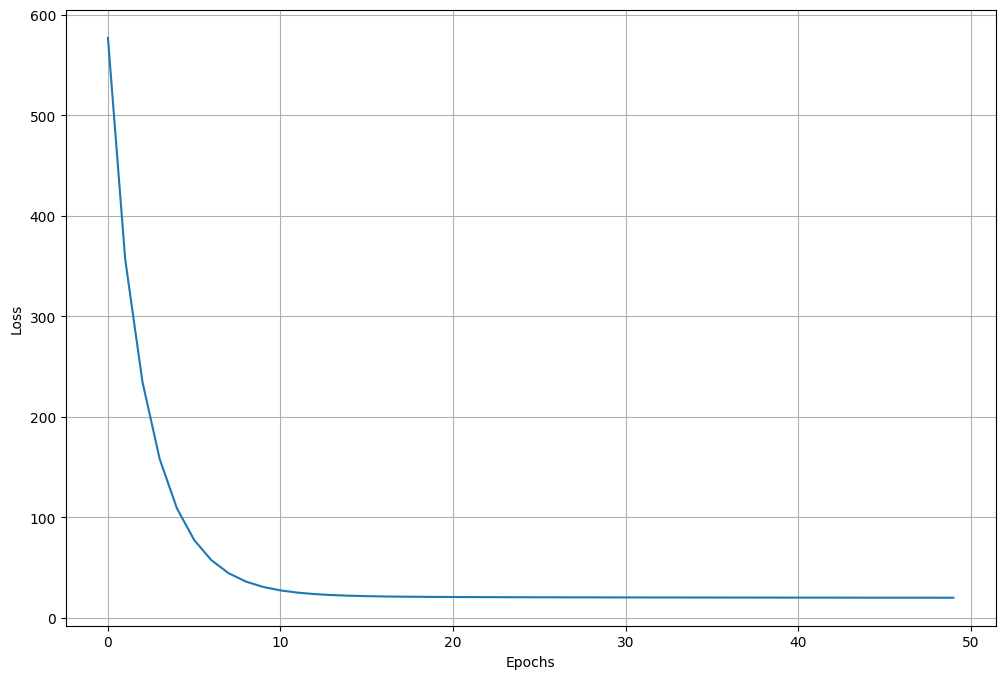

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

La loss converge circa dopo 15 epoche e resta stabile intorno a 20, ma ciò succede sul training, chissà come si compota con i dati di testing...

In [25]:
yt = linear_regression(X_testing_norm, theta, theta_0)
print(loss(yt,Y_testing))

tensor(42.8920, grad_fn=<MeanBackward0>)


Abbiamo ottenuto una loss circa il doppio del training, quindi c'è un po' di overfitting. Per capire come evolve la loss di test sarebbe interessante capirne la traiettoria durante la fase di training. Facciamolo!

In [26]:
learning_rate = 0.1
epochs = 50

# Normalizziamo i dati
# Già fatto in X_training_norm e X_testing_norm

# Inizializziamo i pesi
theta = torch.Tensor(13)
theta.normal_(0,0.01)

theta_0 = torch.Tensor(1)
theta_0.normal_(0,0.01)

theta.requires_grad_(True)
theta_0.requires_grad_(True)

losses_train = []
losses_test = []

for e in range(epochs):
    # Calcoliamo le predizioni
    y = linear_regression(X_training_norm, theta, theta_0)

    # Calcoliamo la loss function
    l = loss(y, Y_training)

    # Calcoliamo il gradiente della loss
    l.backward()

    # Memorizziamo la loss
    losses_train.append(l.item())

    # Aggiorniamo i pesi
    theta.data.sub_(learning_rate*theta.grad.data)
    theta_0.data.sub_(learning_rate*theta_0.grad.data)

    # Azzeriamo i gradienti per evitare di accumularli
    theta.grad.data.zero_()
    theta_0.grad.data.zero_()

    # Calcoliamo la loss sul test, qui non serve calcolare i gradienti
    with torch.set_grad_enabled(False):
        y_test = linear_regression(X_testing_norm, theta, theta_0)
        loss_test = loss(y_test, Y_testing)
        losses_test.append(loss_test.item())




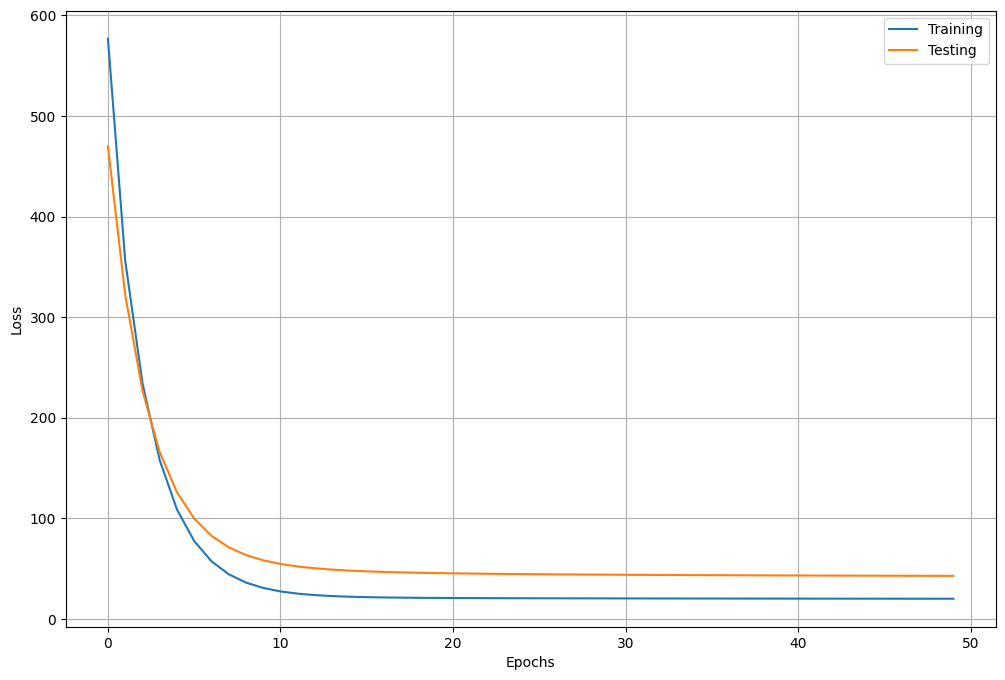

In [27]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(12,8))
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(['Training','Testing'])
plt.show()

Anche la loss converge ma a valori più alti. Aumentare le epoche aiuterebbe?
No perchè aumentare le epoche comporta un continuo adattamento del modello ai dati di training e non migliora le capacità di generalizzare.

# API PyTorch

Per velocizzare la scrittura del codice PyTorch mette a disposizione una API ad oggetti.
Vediamo come fare un regressore lineare con questi strumenti.


In PyTorch ogni pezzo di codice che effettua computazioni è un oggetto Module che include:
1. Trasformazioni lineari
2. Funzione logistica e varie
3. Loss
4. Reti neurali costruite dall'utente
Dentro torch.nn troviamo il modulo Linear che contiene trasformazioni lineari del tipo $y=Ax^T+b$

Dove:
- x è la matrice degli elementi di input di dimensione (N,n) dove N campioni e n features
- A è la matrice dei pesi di dimensione (m,n) dove m dim. dati in uscita ed n dim. dati in entrata
- b è il bias di dimensione m
- y è la matrice degli elementi di output con dimensione (m,N)
In pratica possiamo trasformare i dati da n dimensioni ad m dimensioni tramite parametri A e b

In [28]:
from torch import nn

linear = nn.Linear(20,10)

par = list(linear.parameters())
print(par[0].shape) # Matrice A(m,n)
print(par[1].shape) # Vettore(m)

torch.Size([10, 20])
torch.Size([10])


In [29]:
import torch

# Costruiamo una matrice di 150 elementi a 20 dimensioni
sample_input = torch.rand((150,20))

# Otteniamo una matrice di 150 elementi a 10 dimensioni
sample_output = linear(sample_input)

print(sample_output.shape)

torch.Size([150, 10])


In [30]:
linreg = nn.Linear(13,1)
z = linreg(X_training_norm)
print(z.shape)

torch.Size([456, 1])


PyTorch mette a disposizione anche una funzione di loss

In [31]:
mse = nn.MSELoss()

print("Loss di PyTorch:", mse(z, Y_training.view(-1,1)))
print("Loss utente:", loss(z, Y_training.view(-1,1)))

Loss di PyTorch: tensor(583.5792, grad_fn=<MseLossBackward0>)
Loss utente: tensor(583.5792, grad_fn=<MeanBackward0>)


Stesso risultato ma meglio usare sempre i moduli standard.

Ogni nuovo modello implementato in PyTorch deve essere un modulo, è utile perchè possiamo mantenere tutti i parametri nell'oggetto, dare implementazioni di diversi modelli in maniera simile, e possiamo salvare e caricare modelli correttamente.

Per definire un modulo ereditiamo la classe Module e implementiamo il costruttore, per specificare come bisogna costruire il modulo, e il metodo forward che specifica cosa fare quando il modulo viene chiamato

Possiamo anche definire comportamenti diversi tra training e test, ciò può essere utile per far si che un regressore logistico restituisca le probabiità in fase di test e i logits in fase di training, _potendo usare una loss numericamente stabile (?)_

In [32]:
class LinearRegressor(nn.Module):
    def __init__(self, in_size, out_size):
        """ Costruisce un regressore logistico
            Input:
                - in_size: numero di feature di input
                - out_size: numero di elementi in output """
        
        super(LinearRegressor, self).__init__() # Devo richiamare il costruttore della superclasse

        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        """Definisce come processare x"""
        return self.linear(x)

Con i moduli possiamo utilizzare caratteristiche automatiche come ottenere la lista dei parametri del modulo

In [33]:
reg = LinearRegressor(13,1)
print(list(reg.parameters()))

[Parameter containing:
tensor([[ 0.1109, -0.2135, -0.2508, -0.2333,  0.0270, -0.0753, -0.0312,  0.2009,
          0.1694, -0.1469, -0.0047, -0.2152, -0.1842]], requires_grad=True), Parameter containing:
tensor([-0.2486], requires_grad=True)]


Viene semplificata anche l'algoritmo della discesa del gradiente, useremo il modulo più semplice ovvero SGD, prende in input la lista dei parametri da ottimizzare e il learning rate. 

I passaggi diventano:
1. Costruire il modulo che implementa il modello
2. Mettere il modello in modalità training
3. Calcola la predizione del modello
4. Calcola il valore della loss function
5. Calcola il gradiente della loss function
6. Aggiorna i pesi tramite l'optimizer
7. Ripeti 4-7 fino a convergenza

In [34]:
learning_rate = 0.1
epochs = 100

# Normalizziamo
means = X_training.mean(0)
stds = X_training.std(0)

X_training_norm = (X_training-means)/stds
X_testing_norm = (X_testing-means)/stds

reg = LinearRegressor(13,1)
criterion = nn.MSELoss() # Si chiama così perchè la loss è il criterio di ottimizzazione

# L'optimizer vuole un riferimento ai parametri e il learning rate
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

losses_train = []
losses_test = []

for e in range(epochs):
    reg.train() # Entriamo in modalità training
    output = reg(X_training_norm)
    l = criterion(output.view(-1),Y_training)
    losses_train.append(l.item())

    l.backward()

    optimizer.step()
    optimizer.zero_grad()

    # Calcoliamo la loss di test e mettiamo il modello in modalità validation
    reg.eval()

    with torch.set_grad_enabled(False):
        y_test = reg(X_testing_norm)
        l = criterion(y_test.view(-1), Y_testing)
        losses_test.append(l.item())


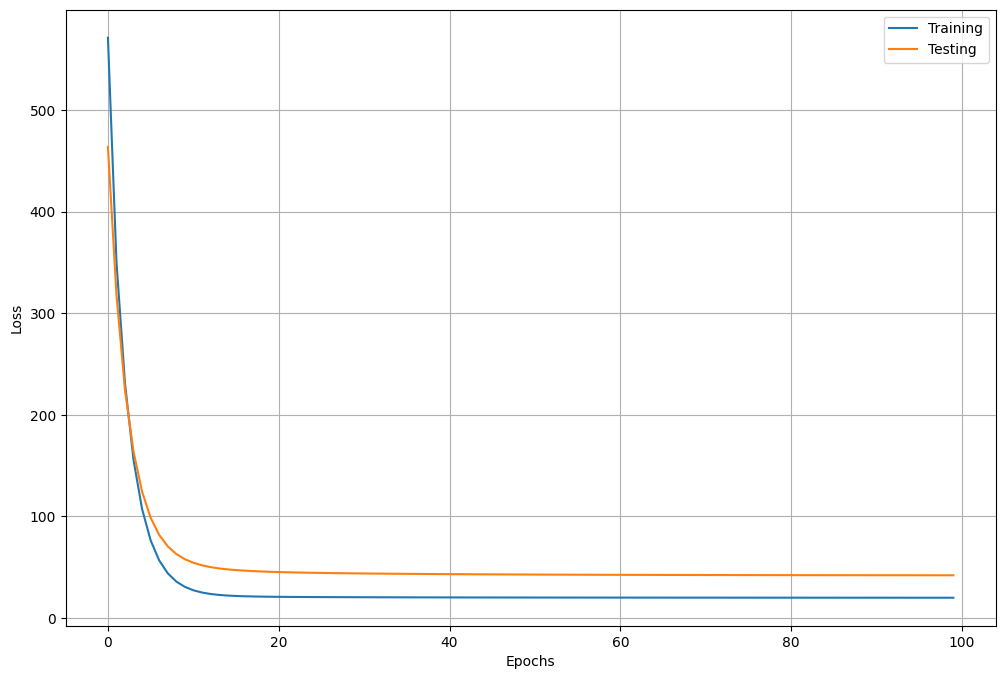

In [35]:
from matplotlib import pyplot as plt 
plt.figure(figsize=(12,8))
plt.plot(losses_train)
plt.plot(losses_test)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend(["Training","Testing"])
plt.show()

# Monitoraggio procedura di training

Abbiamo visto come il plot di training e test indichi quanto il tutto sia andato a buon fine, con modelli più complessi la procedura di training può durare anche ore. In questi casi è utile monitorare le loss durante la procedura. Per far ciò usiamo tensorboard, uno strumento per monitoraggio di training, pytorch la supporta nativamente. 

Ci servono:
- La libreria tensorboard, tramite la quale possiamo scrivere file di log visualizzabili tramite software adatti
- Il software tensorboard, ovvero un web server per la visualizzazione dei dati

installiamo tensorboard tramite conda install tensorboard, creiamo una cartella logs e avviamo il software. Possiamo visualizzare la dashboard a http://localhost:6006/. 

In [36]:
%pip install tensorboard

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
%mkdir logs
%tensorboard --logdir logs

Sottodirectory o file logs gi� esistente.
UsageError: Line magic function `%tensorboard` not found.


In [ ]:
from tensorboard import notebook
notebook.list()  # per controllare se ci sono sessioni attive
notebook.display(port=6006, height=1000)  # o un'altra porta se necessario


Known TensorBoard instances:
  - port 6006: logdir logs (started 0:09:19 ago; pid 33540)
Selecting TensorBoard with logdir logs (started 0:09:19 ago; port 6006, pid 33540).


In [39]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs/test0')

In [40]:
# Simuliamo un ciclo di training
for gs in range(10):
    writer.add_scalar('loss/train', np.sin(gs/5*3.14), global_step=gs)

# Simuliamo un valore di test
writer.add_scalar('loss/test', 1, global_step=gs)

# Simuliamo un secondo ciclo di training
for gs in range(10,20):
    writer.add_scalar('loss/train', np.sin(gs/5*3.14), global_step=gs)

# Simuliamo un secondo valore di test
writer.add_scalar('loss/test', 0.5, global_step=gs)

In [41]:
# Aggiungiamo altri punti al grafico

# Simuliamo un ciclo di training
for gs in range(20,30):
    writer.add_scalar('loss/train', np.sin(gs/5*3.14), global_step=gs)

# Simuliamo un valore di test
writer.add_scalar('loss/test', 1, global_step=gs)

# Simuliamo un secondo ciclo di training
for gs in range(30,40):
    writer.add_scalar('loss/train', np.sin(gs/5*3.14), global_step=gs)

# Simuliamo un secondo valore di test
writer.add_scalar('loss/test', 0.5, global_step=gs)